# SVM and The Kernel Trick 

## Oshri Fatkiev

1. Linear separation using linear kernel 
    1. The number of SVM's as a function of the number of samples
    2. Generalization performence of $\vec{\omega}^{*}$ as a function of the size of the training sample
    3. Comparison between **AdaTron** and **Perceptron** algorithms
    4. Plotting the cosine distance between  $\vec{\omega}^{*}$ and the true plane
2. Nonlinear separation using linear kernel

## Linear separation using linear kernel

First, let us load the libraries and algorithms we need

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from adatron import adatron

import sys

from perceptron import perceptron

plt.style.use(['science', 'notebook', 'grid'])

Next, we load the file contains the data we are going to work with 

In [2]:
filename = 'data_10D.mat'
M = loadmat(filename)
# M

### 1. The number of SVs as a function of the number of samples

Before we begin, let's write a function `train_test_split` that recieves the data `M` and the number of samples we want for training `P` and randomly chooses the training set (and thus the testing set as well)

In [3]:
def train_test_split(M, P):
    shuffled_idxs = np.random.permutation(len(M['y0']))
    train_idxs, test_idxs = shuffled_idxs[:P], shuffled_idxs[P:]
    X_train, X_test = M['X'][:,train_idxs], M['X'][:,test_idxs]
    y_train, y_test = M['y0'][train_idxs], M['y0'][test_idxs]
    return X_train, X_test, y_train, y_test

Now we are ready to start our computations. Our first goal is to try to determine the relation between the average number of SVs (support vectors) needed for the solution and the number of samples `P`.

In [4]:
Ps = [10, 50, 100, 300]
N_REPS = 20
ETA = 0.1

avg_sv_num = np.zeros(len(Ps))
adatron_general_performance = np.zeros(len(Ps))
perceptron_general_performance = np.zeros(len(Ps))

for i, P in enumerate(Ps):
    print(r'P={}'.format(P))
    sv_num = np.zeros(N_REPS)
    adatron_gen_stats = np.zeros(N_REPS)
    perceptron_gen_stats = np.zeros(N_REPS)

    for j in np.arange(N_REPS):
        X_train, X_test, y_train, y_test = train_test_split(M, P)

        a_converged, A = adatron(X_train.T @ X_train, y_train, ETA)
        alphas = A[-1, :]
        sv_num[j] = len(np.nonzero(alphas)[0])
        if a_converged:
            adatron_y_hat = np.zeros(len(y_test)).reshape(-1, 1)
            for k in range(X_test.shape[1]):
                res = np.sum([alphas.T[p] * y_train[p] * np.dot(X_test[:,k],X_train[:,p]) for p in range(P)])
                adatron_y_hat[k] = np.sign(res)
            adatron_gen_stats[j] = np.sum(adatron_y_hat == y_test) / len(y_test)

        w, p_converged, _ = perceptron(X_train, y_train)
        if p_converged:
            perceptron_y_hat = np.sign(w.T @ X_test)
            perceptron_gen_stats[j] = np.sum(perceptron_y_hat.T == y_test) / len(y_test)

    avg_sv_num[i] = np.mean(sv_num)
    if np.count_nonzero(adatron_gen_stats) != 0:
        adatron_general_performance[i] = np.mean(adatron_gen_stats[np.nonzero(adatron_gen_stats)[0]])
    if np.count_nonzero(perceptron_gen_stats) != 0:
        perceptron_general_performance[i] = np.mean(perceptron_gen_stats[np.nonzero(perceptron_gen_stats)[0]])

print('Done!')

P=10
P=50
P=100
P=300
Done!


Plotting the number of support vectors `avg_sv_num` as a function of `Ps` we get

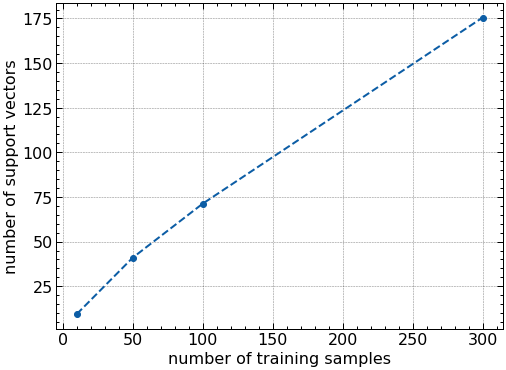

In [5]:
plt.plot(Ps, avg_sv_num, '--o')
plt.xlabel(r'number of training samples')
plt.ylabel(r'number of support vectors')
plt.show()

As we can see, the more training samples we have, the more support vectors were gonna get. Moreover, we can see that to a good approximation, the number of support vectors is linear to the size of the sample. 

### 2. Generalization performence of $\vec{\omega}^{*}$ as a function of the size of the training sample
Next, let's see what is the generalization performence of the optimal solution as a function of `P` 

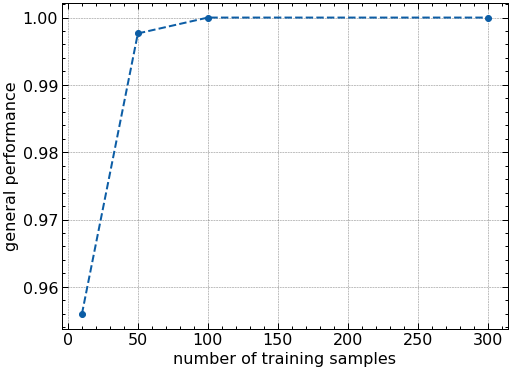

In [6]:
plt.plot(Ps, adatron_general_performance, '--o')
plt.xlabel(r'number of training samples')
plt.ylabel(r'general performance')
plt.show()

As expected, the linear kernel did well on find a seperation between the two different classes.

### 3. Comparison between AdaTron and Perceptron algorithms

Now we are able to compare the generalization performance of AdaTron and Perceptron

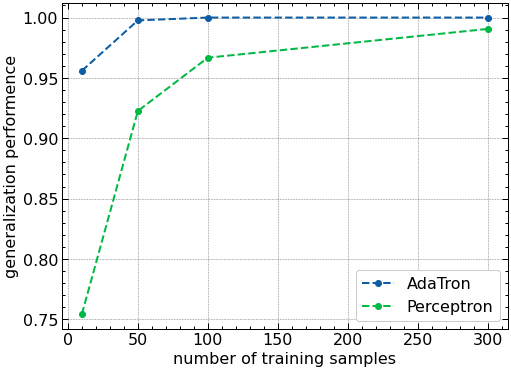

In [7]:
plt.plot(Ps, adatron_general_performance, '--o')
plt.plot(Ps, perceptron_general_performance, '--o')
plt.xlabel(r'number of training samples')
plt.ylabel(r'generalization performence')
plt.legend(['AdaTron', 'Perceptron'])
plt.show()

As expected, as the number of training samples grows, both algorithms generalize better, with a better generaliztion using the AdaTron algorithm.

<!-- ### 4. Plotting the cosine distance between $\vec{\omega}^{*}$ and the true plane -->

## Nonlinear separation using the kernel trick

First, let's implement two well-known kernel functions - polynomial and Gaussian

In [19]:
def kernel_polynomial(X, d):
    K = (X.T @ X + 1) ** d
    return K

def kernel_gaussian(X, sigma):
    P = X.shape[1]
    K = np.zeros((P,P))
    for i in range(P):
        for j in range(P):
            K[i,j] = np.exp(-1/(2*sigma**2)*np.sum((X[:,i] - X[:,j])**2))
    return K

Now, let's import the function we are going to use in this part - `checkerboard`

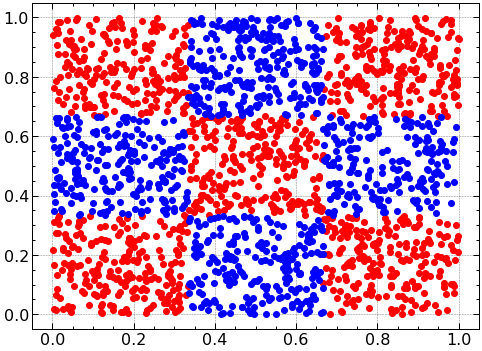

In [20]:
from checkboard import *
test_checkboard()

Let us define a simple function to split the checkboard data

In [21]:
def split_checkboard(P):
    X, y0 = checkboard(N_SAMPLES)
    y0 = y0.reshape(N_SAMPLES, 1)
    X_train, X_test = X[:, :P], X[:, P:]
    y_train, y_test = y0[:P], y0[P:]
    return X_train, X_test, y_train, y_test

We are going to start trying to seperate the checkboard-like data using polynomial kernel. In this section we set the stopping criterion `EPS` to be 0.01, and the maximal number of iterations `T_MAX` to 1e5. In addition, the polynomial degrees we chose `Ds` are `3,6,9` 

In [28]:
EPS = 0.1
T_MAX = 10 ** 5  

P=1000


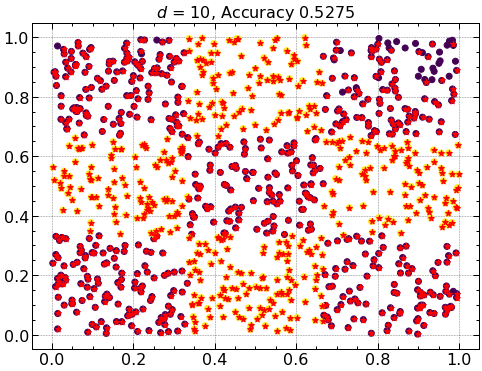

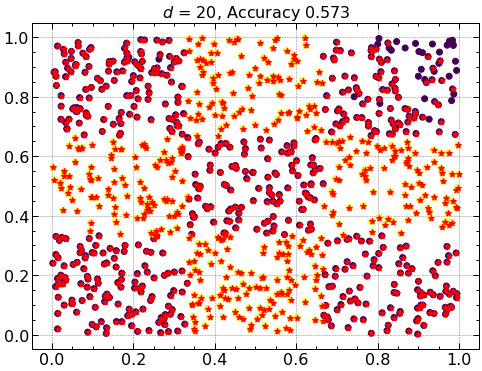

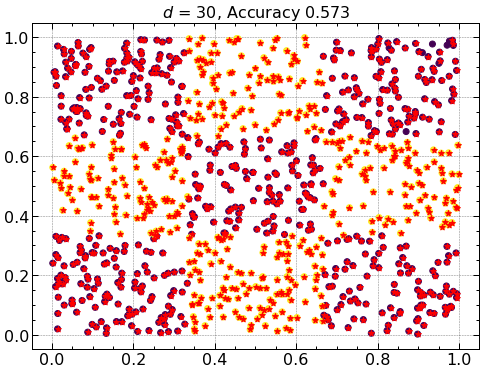

P=2000


KeyboardInterrupt: 

In [16]:
N_SAMPLES = 3000
Ps = [1000, 2000]
Ds = [10, 20, 30]

poly_kernel = lambda x, y, d: (np.dot(x, y) + 1) ** d

for P in Ps:
    print(r'P={}'.format(P))
    X_train, X_test, y_train, y_test = split_checkboard(P)
    
    for D in Ds:
        K_poly = kernel_polynomial(X_train, D)
        converged_poly, A_poly = adatron(K_poly, y_train, EPS, T_MAX)
        if converged_poly:
            poly_y_hat = np.zeros(len(y_test)).reshape(-1, 1)
            for k in range(X_test.shape[1]):
                res = np.sum([A_poly[-1,:].T[p]*y_train[p]*poly_kernel(X_test[:,k],X_train[:,p],D) for p in range(P)])
                poly_y_hat[k] = np.sign(res)
            poly_accuracy = np.round(np.sum(poly_y_hat == y_test) / len(y_test), 4)

        idxs = np.nonzero(A_poly[-1, :])[0]
        plt.scatter(X_train[0, ], X_train[1, ], c=y_train)
        plt.scatter(X_train[0, idxs], X_train[1, idxs], marker='*', c='r')
        plt.title(r'$d$ = {}, Accuracy {}'.format(D, poly_accuracy))
        plt.show()

Next, we try again, this time with the Gaussian kernel. The variations we choose `Vs` are `1,3,5`.

In [35]:
Vs = [0.1, 0.5, 1]

gaus_kernel = lambda x, y, d: np.exp((-1/(2*d**2))*np.sum((x - y)**2))

for P in Ps:
    print(r'P={}'.format(P))
    X_train, X_test, y_train, y_test = split_checkboard(P)
    
    for V in Vs:
        K_gaus = kernel_gaussian(X_train, V)
        converged_gaus, A_gaus = adatron(K_gaus, y_train, EPS, T_MAX)
        if converged_gaus:
            gaus_y_hat = np.zeros(len(y_test)).reshape(-1, 1)
            for k in range(X_test.shape[1]):
                res = np.sum([A_gaus[-1,:].T[p]*y_train[p]*gaus_kernel(X_test[:,k],X_train[:,p],V) for p in range(P)])
                gaus_y_hat[k] = np.sign(res)
            gaus_accuracy = np.round(np.sum(gaus_y_hat == y_test) / len(y_test), 4)

        idxs = np.nonzero(A_gaus[-1,:])[0]
        plt.scatter(X_train[0, ], X_train[1, ], c=y_train)
        plt.scatter(X_train[0, idxs], X_train[1, idxs], marker='*', c='r')
        plt.title(r'$\sigma$ = {}, Accuracy {}'.format(V, gaus_accuracy))
        plt.show()

P=1000


KeyboardInterrupt: 

In both cases, we get an constant accuracy and the algorithm determines all the samples as support vectors. I am not sure what is causing it although I tried deubugging it in the time left before the submission closes and it seems like the predictions `gaus_y_hat` and `poly_y_hat` only contains (-1)s, and that probably explains the constant accuracy.